<a href="https://colab.research.google.com/github/lochieh19798/Data-analysis/blob/main/Figure2mod.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Edition control

In [14]:
!git config --global user.name "lochieh19798"
!git config --global user.email "lochieh19798@gmail.com"

In [15]:
!git clone https://github.com/lochieh19798/data-analysis

fatal: destination path 'data-analysis' already exists and is not an empty directory.


In [16]:
# ╔═╡ Cell 0 ═════════════════════════════════════════════════════════════╗
# If you’re on Colab, install any non-preinstalled libraries:
!pip install -q catboost shap scikit-learn==1.4.2 matplotlib pandas numpy
!pip install -q --upgrade xgboost
!pip install -q shap --no-deps

In [17]:
from xgboost.sklearn import XGBModel
XGBModel.feature_weights = None
print("Patched XGBModel.feature_weights →", XGBModel.feature_weights)

Patched XGBModel.feature_weights → None


In [18]:
# ╔═╡ Cell 1 ═════════════════════════════════════════════════════════════╗
# Imports & global configuration
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xgboost as xgb
from IPython.display import display

from sklearn.model_selection import (
    train_test_split,
    StratifiedKFold,
    GridSearchCV,
    RandomizedSearchCV
)
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import (
    OneHotEncoder,
    StandardScaler,
    OrdinalEncoder
)
from sklearn.impute import (
    KNNImputer,
    SimpleImputer
    # ← no IterativeImputer here
)
from sklearn.metrics import roc_auc_score, RocCurveDisplay

# Classifiers
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import (
    ExtraTreesClassifier,
    AdaBoostClassifier,
    HistGradientBoostingClassifier
)
from xgboost import XGBClassifier
from catboost import CatBoostClassifier

RANDOM_STATE = 42
plt.style.use("default")


In [19]:
# ╔═╡ Cell 2 – load data & build feature lists with missing‐% report ═════╝
from pathlib import Path
import pandas as pd

# 1. Data‐loading helper (as before)
DATA_PATH = "/content/data-analysis/CRYOANALYSIS.csv"
def load_and_prepare_data(csv_path: str = DATA_PATH) -> pd.DataFrame:
    df = pd.read_csv(csv_path)
    # (1) Recurrence flags
    df["Survival_time"] = pd.to_numeric(df["Survival_time"], errors="coerce")
    df = df.dropna(subset=["Survival_time", "Recurrence"])
    df["Recurrence_1yr"] = ((df["Survival_time"] <= 365) & (df["Recurrence"] == 1)).astype(int)
    df["Recurrence_2yr"] = ((df["Survival_time"] <= 730) & (df["Recurrence"] == 1)).astype(int)
    # (2) AF type one‐hot
    af_col = "Baseline AF Type(1=paroxysmal, 2=persistent)"
    df["AF_Parox"]   = (df[af_col] == 1).astype(int)
    df["AF_Persist"] = (df[af_col] == 2).astype(int)
    return df

# 2. Load the dataset
DATA_PATH = Path("/content/data-analysis/CRYOANALYSIS.csv")
assert DATA_PATH.exists(), f"{DATA_PATH} not found – upload it first!"
df = load_and_prepare_data(DATA_PATH)

# 3. Feature lists
cont = [
    "age", "BMI",
    "Baseline LVEF", "Baseline LAD", "CHA2DS2VASc score", "CHAD2 score", "AF_time_procedure",
    "Total no of ablation application number", "Mobility question (Baseline)",
    "Self-care question (Baseline)", "Usual activities question (Baseline)",
    "Pain/Discomfort question (Baseline)", "Anxiety/Depression question (Baseline)",
    "Visual analogue score: Your own health state today (Baseline)",
    "Total procedure time: Venous access to last cryoatheter removal (mins)",
    "Total fluoro time (mins)", "Energy duration LSPV", "Coldest Temperature LSPV",
    "Energy duration LIPV", "Coldest Temperature LIPV",
    "Energy duration RSPV", "Coldest temperature RSPV",
    "Energy duration RIPV", "Coldest Temperature RIPV",
    "Left atrial dwell time: time from first cryocatheter insertion to last cryocatheter removal (mins)",
    "Change in EQ 5D"
    # "Time to isolation LSPV", "Time to isolation LIPV", "Time to isolation RSPV","Time to isolation RIPV",
]

cat = [
    "Sex (F=1, M=0)", "Hypertension", "Diabetes", "HF", "CAD", "stroke",
    "History of TIA", "Subject taking Class I or III AAD at baseline (1=Yes, 0=No)",
    "LSPV isolated", "LIPV PV isolated", "RSPV Isolated", "RIPV isolated",
    "Were all targeted PVs isolated (Investigator)?",
    "AF_Parox", "AF_Persist",
    "CTI ablation",
    "Non-PVI ablation performed",
    "Was subject taking Class I or Class III AAD at procedure discharge?",
    "Mapping/navigational tools: Intracardiac echocardiography (ICE)",
    "Pre Procedural CT",
    "Ensite 3D mapping"
]

TARGET = "Recurrence_2yr"

# 4. Report missing‐value percentages for every feature
all_feats = cont + cat
missing_pct = df[all_feats].isna().mean() * 100
missing_report = (
    missing_pct
      .sort_values(ascending=False)
      .rename("missing_pct")
      .reset_index()
      .rename(columns={"index": "variable"})
)
print("📊 Missing Value Percentage per Feature:")
print(missing_report.to_string(index=False, float_format="%.1f%%"))

# 5. Gentle column check: warn & drop if still missing
missing_cont = [c for c in cont if c not in df.columns]
missing_cat  = [c for c in cat  if c not in df.columns]
if missing_cont or missing_cat:
    print("\n⚠️  WARNING – some expected columns are missing and will be skipped.")
    print("   Missing continuous :", missing_cont)
    print("   Missing categorical:", missing_cat)

cont = [c for c in cont if c in df.columns]
cat  = [c for c in cat  if c in df.columns]

# From here on, the rest of the notebook runs as before...


📊 Missing Value Percentage per Feature:
                                                                                          variable  missing_pct
                                                                                      Baseline LAD        32.7%
                                                                                   Change in EQ 5D        27.0%
                                                            Anxiety/Depression question (Baseline)        25.6%
                                                               Pain/Discomfort question (Baseline)        25.6%
                                                              Usual activities question (Baseline)        25.6%
                                                                     Self-care question (Baseline)        25.6%
                                     Visual analogue score: Your own health state today (Baseline)        25.6%
                                                                

In [20]:
# ╔═╡ Cell 3 – event‐rate–balanced temporal hold-out ═════════════════╗
import numpy as np
from datetime import datetime

# 1) Ensure date column and sort
df["ProcedureDate"] = pd.to_datetime(df["ProcedureDate"])
df_sorted = df.sort_values("ProcedureDate")

# 2) Compute overall event rate
full_rate = df_sorted[TARGET].mean()

# 3) Search for the best cutoff fraction (between 60% and 95% of the data)
n = len(df_sorted)
best_diff = np.inf
best_idx = None
best_frac = None

for frac in np.linspace(0.60, 0.95, 36):            # try 0.60, 0.61, …, 0.95
    idx = int(n * frac)
    test_slice = df_sorted.iloc[idx:]
    test_rate = test_slice[TARGET].mean()
    diff = abs(test_rate - full_rate)
    if diff < best_diff:
        best_diff = diff
        best_idx  = idx
        best_frac = frac

# 4) Slice into train / test
train_df = df_sorted.iloc[:best_idx]
test_df  = df_sorted.iloc[best_idx:]

X_train = train_df[cont + cat]
y_train = train_df[TARGET].astype(int)
X_test  = test_df [cont + cat]
y_test  = test_df [TARGET].astype(int)

# 5) Report
print(f"🔎 Chosen cutoff at {best_frac*100:.1f}% of data (row {best_idx} / {n})")
print(f"   • Overall event rate:  {full_rate:.2%}")
print(f"   • Train event rate:    {y_train.mean():.2%}")
print(f"   • Test event rate:     {y_test.mean():.2%}")
print(f"   • Train/Test sizes:    {len(y_train)} / {len(y_test)}")


🔎 Chosen cutoff at 95.0% of data (row 266 / 281)
   • Overall event rate:  19.22%
   • Train event rate:    19.17%
   • Test event rate:     20.00%
   • Train/Test sizes:    266 / 15


In [22]:
# ╔═╡ Cell 4 – Pre-processing pipelines ═══════════════════════════════════╗
# (Make sure to enable the experimental IterativeImputer)
from sklearn.experimental import enable_iterative_imputer
from sklearn.pipeline           import Pipeline
from sklearn.impute             import IterativeImputer, SimpleImputer
from sklearn.preprocessing      import StandardScaler, PowerTransformer, OneHotEncoder
from sklearn.compose            import ColumnTransformer

# Numeric pipeline: iterative imputation → power transform → scaling
numeric_pipe = Pipeline([
    ("impute", IterativeImputer(random_state=RANDOM_STATE)),
    ("power",  PowerTransformer(method="yeo-johnson")),
    ("scale",  StandardScaler())
])

# Categorical pipeline: fill missing with "Missing" → one-hot encode
categorical_pipe = Pipeline([
    ("impute", SimpleImputer(strategy="constant", fill_value="Missing")),
    ("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
])

# Full preprocessor: apply to continuous and categorical lists
preprocessor = ColumnTransformer([
    ("num", numeric_pipe,       cont),
    ("cat", categorical_pipe,   cat)
], remainder="drop")


In [23]:
# ╔═╡ Cell 4b – preview IterativeImputer + PowerTransformer on numeric features ═══════╗
import warnings
from sklearn.exceptions import ConvergenceWarning

# (Optionally suppress FutureWarnings or ConvergenceWarnings)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=ConvergenceWarning)

# 1. Show missing counts before
num_train = X_train[cont].copy()
print("🔴 Missing before imputation (numeric features):")
print(num_train.isna().sum())

# 2. Fit & transform with your updated numeric_pipe
num_imputed = pd.DataFrame(
    numeric_pipe.fit_transform(num_train),
    columns=cont,
    index=num_train.index
)

# 3. Show missing counts after
print("\n🟢 Missing after IterativeImputer + PowerTransformer:")
print(num_imputed.isna().sum())

# 4. Display first few rows of the transformed DataFrame
display(num_imputed.head())


🔴 Missing before imputation (numeric features):
age                                                                                                    0
BMI                                                                                                    1
Baseline LVEF                                                                                         67
Baseline LAD                                                                                          92
CHA2DS2VASc score                                                                                      0
CHAD2 score                                                                                            0
AF_time_procedure                                                                                     27
Total no of ablation application number                                                                0
Mobility question (Baseline)                                                                          57
Self-ca

,age,BMI,Baseline LVEF,Baseline LAD,CHA2DS2VASc score,CHAD2 score,AF_time_procedure,Total no of ablation application number,Mobility question (Baseline),Self-care question (Baseline),...,Energy duration LSPV,Coldest Temperature LSPV,Energy duration LIPV,Coldest Temperature LIPV,Energy duration RSPV,Coldest temperature RSPV,Energy duration RIPV,Coldest Temperature RIPV,Left atrial dwell time: time from first cryocatheter insertion to last cryocatheter removal (mins),Change in EQ 5D
75,0.399692,-0.570958,0.427682,0.083904,-0.486356,-1.087458,-0.684578,-0.186691,-0.333216,-0.019546,...,-0.143079,-0.421816,0.038760,-0.050434,0.182243,-0.892740,0.010049,-0.396401,-0.691231,0.082178
76,-1.795640,-0.603407,-1.448736,0.051441,1.378727,1.554814,-0.424051,-0.672876,-0.333216,-0.019546,...,-0.143079,0.894053,0.038760,0.729472,-0.270965,0.066764,-1.451648,1.185403,0.023297,0.082178
77,-0.844880,1.557260,0.243856,0.838752,0.300340,0.433812,-0.539760,-0.186691,-0.333216,-0.019546,...,-0.143079,0.545115,0.038760,0.339735,-0.131069,-1.335765,0.010049,-0.396401,-0.511106,0.738092
78,1.044861,0.695287,-1.107116,2.051353,1.378727,1.130668,0.018983,-0.186691,-0.333216,-0.019546,...,1.075518,-1.528501,-0.037728,-3.185390,-0.227636,-0.684318,0.010049,0.853021,-0.737626,0.413900
285,0.502461,-0.570958,-0.570825,-0.212510,-0.486356,0.433812,0.907808,0.314968,-0.333216,-0.019546,...,-0.143079,0.545115,1.808903,-0.050434,-0.336447,-0.684318,-1.608571,-0.246521,0.211666,0.082178


In [25]:
# ╔═╡ Cell 4c – preview string-cast → impute → one-hot on categorical features ═══════╗
from sklearn.pipeline          import Pipeline
from sklearn.preprocessing     import FunctionTransformer, OneHotEncoder
from sklearn.impute            import SimpleImputer
import pandas as pd

# 1) Re-define categorical_pipe to cast → impute → one-hot
categorical_pipe = Pipeline([
    # cast every value to string
    ("to_str",   FunctionTransformer(lambda X: X.astype(str), validate=False)),
    # fill missing with literal "Missing"
    ("impute",   SimpleImputer(strategy="constant", fill_value="Missing")),
    # one-hot encode the strings
    ("onehot",   OneHotEncoder(handle_unknown="ignore", sparse_output=False))
])

# 2. Grab the raw cat columns (with NaNs)
cat_train = X_train[cat].copy()
print("🔴 Missing before imputation (categorical features):")
print(cat_train.isna().sum())

# 3. Fit & transform via the updated pipeline
cat_ohe_array = categorical_pipe.fit_transform(cat_train)

# 4. Turn back into a DataFrame
cat_ohe_cols = categorical_pipe.named_steps["onehot"].get_feature_names_out(cat)
cat_imputed  = pd.DataFrame(cat_ohe_array, columns=cat_ohe_cols, index=cat_train.index)

print("\n🟢 Missing after to_str → SimpleImputer → OneHotEncoder:")
print(cat_imputed.isna().sum().sum(), "total NaNs remaining")

print("\n🖨️ Sample of the imputed one-hot matrix:")
display(cat_imputed.iloc[:, :10].head())


🔴 Missing before imputation (categorical features):
Sex (F=1, M=0)                                                          0
Hypertension                                                            0
Diabetes                                                                0
HF                                                                      0
CAD                                                                     0
stroke                                                                  0
History of TIA                                                          0
Subject taking Class I or III AAD at baseline (1=Yes, 0=No)             8
LSPV isolated                                                           2
LIPV PV isolated                                                        3
RSPV Isolated                                                           2
RIPV isolated                                                           2
Were all targeted PVs isolated (Investigator)?              

,"Sex (F=1, M=0)_0","Sex (F=1, M=0)_1",Hypertension_0,Hypertension_1,Diabetes_0,Diabetes_1,HF_0,HF_1,CAD_0,CAD_1
75,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
76,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0
77,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0
78,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0
285,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0


In [26]:
# ╔═╡ Cell 4d – inspect full preprocessed feature space ─══════════════╗
from sklearn.compose import ColumnTransformer

# 1) Re‐build the ColumnTransformer as in Cell 4
ct = ColumnTransformer([
    ("num", numeric_pipe, cont),
    ("cat", categorical_pipe, cat)
], remainder="drop")

# 2) Fit & transform your training set
X_tr_full = ct.fit_transform(X_train)

# 3) Manually assemble the feature names:
#    - numeric features keep their original names
num_features = cont

#    - categorical features come from the OneHotEncoder inside categorical_pipe
cat_ohe_names = categorical_pipe.named_steps["onehot"] \
                     .get_feature_names_out(cat)

#    - combine
feat_names = list(num_features) + list(cat_ohe_names)

# 4) Report
print(f"➡️  Combined train matrix: {X_tr_full.shape[0]} rows × {X_tr_full.shape[1]} cols")
print(f"📦  Total features = {len(feat_names)}")
print("🔍  Example feature names:", feat_names[:10], "…", feat_names[-10:])

# 5) (optional) display the first few rows in a DataFrame
import pandas as pd
df_feats = pd.DataFrame(X_tr_full, columns=feat_names, index=X_train.index)
df_feats.head()


➡️  Combined train matrix: 266 rows × 76 cols
📦  Total features = 76
🔍  Example feature names: ['age', 'BMI', 'Baseline LVEF', 'Baseline LAD', 'CHA2DS2VASc score', 'CHAD2 score', 'AF_time_procedure', 'Total no of ablation application number', 'Mobility question (Baseline)', 'Self-care question (Baseline)'] … ['Was subject taking Class I or Class III AAD at procedure discharge?_0', 'Was subject taking Class I or Class III AAD at procedure discharge?_1', 'Mapping/navigational tools: Intracardiac echocardiography (ICE)_0', 'Mapping/navigational tools: Intracardiac echocardiography (ICE)_1', 'Pre Procedural CT_0.0', 'Pre Procedural CT_1.0', 'Pre Procedural CT_nan', 'Ensite 3D mapping_0.0', 'Ensite 3D mapping_1.0', 'Ensite 3D mapping_nan']


,age,BMI,Baseline LVEF,Baseline LAD,CHA2DS2VASc score,CHAD2 score,AF_time_procedure,Total no of ablation application number,Mobility question (Baseline),Self-care question (Baseline),...,Was subject taking Class I or Class III AAD at procedure discharge?_0,Was subject taking Class I or Class III AAD at procedure discharge?_1,Mapping/navigational tools: Intracardiac echocardiography (ICE)_0,Mapping/navigational tools: Intracardiac echocardiography (ICE)_1,Pre Procedural CT_0.0,Pre Procedural CT_1.0,Pre Procedural CT_nan,Ensite 3D mapping_0.0,Ensite 3D mapping_1.0,Ensite 3D mapping_nan
75,0.399692,-0.570958,0.427682,0.083904,-0.486356,-1.087458,-0.684578,-0.186691,-0.333216,-0.019546,...,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
76,-1.795640,-0.603407,-1.448736,0.051441,1.378727,1.554814,-0.424051,-0.672876,-0.333216,-0.019546,...,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
77,-0.844880,1.557260,0.243856,0.838752,0.300340,0.433812,-0.539760,-0.186691,-0.333216,-0.019546,...,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
78,1.044861,0.695287,-1.107116,2.051353,1.378727,1.130668,0.018983,-0.186691,-0.333216,-0.019546,...,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
285,0.502461,-0.570958,-0.570825,-0.212510,-0.486356,0.433812,0.907808,0.314968,-0.333216,-0.019546,...,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0


In [28]:
# ------------- 4.3 Define candidate models ------------------------------
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_pipe, cont),
        ("cat", categorical_pipe, cat)
    ],
    remainder="drop"   # or "passthrough" if you have other cols
)

In [29]:
# ╔═╡ Cell 4.4 – helper for CatBoost (just fill categoricals) ═════════════╗
def prepare_for_catboost(
    X: pd.DataFrame,
    cat_cols: list[str]
) -> pd.DataFrame:
    """
    Copy X, replace any NaN in the specified categorical columns
    with a literal 'Missing' string (so CatBoost sees it as a valid category).
    Leave all other columns untouched (CatBoost will handle numeric NaNs if any).
    """
    X_cb = X.copy()
    for c in cat_cols:
        X_cb[c] = X_cb[c].fillna("Missing").astype(str)
    return X_cb


In [30]:
# # ╔═╡ Cell 4.5 — tune XGBoost rounds with native CV ═══════════════════════╗
# import xgboost as xgb

# # 1. Build DMatrix
# dtrain = xgb.DMatrix(X_train, label=y_train)

# # 2. Define a base params dict (everything except n_estimators)
# xgb_params = {
#     "objective":        "binary:logistic",
#     "eval_metric":      "auc",
#     "learning_rate":    0.01,
#     "max_depth":        5,
#     "subsample":        0.8,
#     "colsample_bytree": 0.8,
#     "gamma":            1.0,
#     "reg_alpha":        0.1,
#     "reg_lambda":       1.0,
#     "scale_pos_weight": float((y_train==0).sum()) / (y_train==1).sum(),
#     "tree_method":      "hist"   # or 'auto'
# }

# # 3. Run CV with early stopping
# cv_results = xgb.cv(
#     params=xgb_params,
#     dtrain=dtrain,
#     num_boost_round=2000,
#     nfold=5,
#     metrics=("auc",),
#     early_stopping_rounds=50,
#     seed=RANDOM_STATE,
#     as_pandas=True,
#     verbose_eval=50
# )

# best_n_rounds = len(cv_results)
# best_auc = cv_results["test-auc-mean"].max()
# print(f"🔎 Optimal rounds: {best_n_rounds}, CV-AUC: {best_auc:.4f}")

In [34]:
# ╔═╡ Cell 4.6 – Faster tune of ExtraTrees via RandomizedSearchCV with SMOTE ═╗
from imblearn.pipeline      import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble       import ExtraTreesClassifier
import numpy as np

# 1) Pipeline: impute/encode → SMOTE → ExtraTrees
et_pipe = ImbPipeline([
    ("prep", preprocessor),
    ("smote", SMOTE(random_state=RANDOM_STATE)),
    ("clf", ExtraTreesClassifier(
        random_state=RANDOM_STATE,
        class_weight="balanced",
        n_jobs=-1          # speed up individual fits
    ))
])

# 2) Narrower/random search space
param_dist = {
    "clf__n_estimators":     [100, 300, 500, 800],
    "clf__max_depth":        [None, 10, 20],
    "clf__max_features":     ["sqrt", "log2"],
    "clf__min_samples_split":[2, 5],
    "clf__min_samples_leaf": [1, 2]
}

# 3) RandomizedSearchCV – just 30 draws instead of 720 fits
et_rand = RandomizedSearchCV(
    et_pipe,
    param_distributions=param_dist,
    n_iter=30,             # only 30 random combinations
    scoring="roc_auc",
    cv=3,
    n_jobs=-1,
    verbose=1,
    random_state=RANDOM_STATE,
    refit=True
)

# 4) Fit
et_rand.fit(X_train, y_train)

print("✅ Best ExtraTrees params:", et_rand.best_params_)
print("✅ Best CV AUC:         ", et_rand.best_score_)

# 5) Save the params
best_et_params = {
    "n_estimators":     et_rand.best_params_["clf__n_estimators"],
    "max_depth":        et_rand.best_params_["clf__max_depth"],
    "max_features":     et_rand.best_params_["clf__max_features"],
    "min_samples_split":et_rand.best_params_["clf__min_samples_split"],
    "min_samples_leaf": et_rand.best_params_["clf__min_samples_leaf"]
}

best_et_n      = best_et_params["n_estimators"]
best_et_depth  = best_et_params["max_depth"]
best_et_feats  = best_et_params["max_features"]
best_et_split  = best_et_params["min_samples_split"]
best_et_leaf   = best_et_params["min_samples_leaf"]

Fitting 3 folds for each of 30 candidates, totalling 90 fits
✅ Best ExtraTrees params: {'clf__n_estimators': 100, 'clf__min_samples_split': 2, 'clf__min_samples_leaf': 1, 'clf__max_features': 'log2', 'clf__max_depth': 20}
✅ Best CV AUC:          0.49971807972015103


In [32]:
# ╔═╡ Cell 4.8 – Randomized tune for HistGB with SMOTE ─═════════════════╗
from imblearn.pipeline      import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE
from sklearn.ensemble       import HistGradientBoostingClassifier
from sklearn.model_selection import RandomizedSearchCV

# 1) Pipeline: preprocess → SMOTE → HistGB
hgb_pipe = ImbPipeline([
    ("prep", preprocessor),
    ("smote", SMOTE(random_state=RANDOM_STATE)),
    ("clf", HistGradientBoostingClassifier(
        loss="log_loss",
        early_stopping="auto",
        validation_fraction=0.1,
        n_iter_no_change=20,
        random_state=RANDOM_STATE
    ))
])

# 2) A richer space
param_dist = {
    "clf__learning_rate":      [0.005, 0.01, 0.03, 0.05, 0.1],
    "clf__max_iter":           [200, 500, 1000, 1500],
    "clf__max_depth":          [None, 3, 5, 7],
    "clf__min_samples_leaf":   [20, 50, 100],
    "clf__l2_regularization":  [0.0, 0.1, 1.0, 5.0],
    "clf__max_leaf_nodes":     [15, 31, 63]
}

# 3) RandomizedSearchCV – 30 draws, 3-fold CV
hgb_rand = RandomizedSearchCV(
    hgb_pipe,
    param_distributions=param_dist,
    n_iter=30,
    scoring="roc_auc",
    cv=3,
    n_jobs=-1,
    verbose=1,
    random_state=RANDOM_STATE,
    refit=True
)

# 4) Fit it
hgb_rand.fit(X_train, y_train)

# 5) Capture the winner
best_hgb_params = {
    k.replace("clf__", ""): v
    for k, v in hgb_rand.best_params_.items()
}
print("✅ Best HistGB params:", best_hgb_params,
      "→ CV AUC:", hgb_rand.best_score_)


Fitting 3 folds for each of 30 candidates, totalling 90 fits
✅ Best HistGB params: {'min_samples_leaf': 100, 'max_leaf_nodes': 31, 'max_iter': 200, 'max_depth': 5, 'learning_rate': 0.005, 'l2_regularization': 1.0} → CV AUC: 0.5827234649728437


In [71]:
# ╔═╡ Cell 5 – Build models dict with SMOTE in every pipeline ─════════╗
from imblearn.pipeline       import Pipeline as ImbPipeline
from imblearn.over_sampling  import SMOTE
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
import numpy as np

models = {
    "LogReg": RandomizedSearchCV(
        ImbPipeline([
            ("prep",  preprocessor),
            ("smote", SMOTE(random_state=RANDOM_STATE)),
            ("clf",   LogisticRegression(
                          solver="saga",
                          penalty="elasticnet",
                          l1_ratio=0.5,
                          class_weight="balanced",
                          max_iter=5000,
                          random_state=RANDOM_STATE
                      ))
        ]),
        param_distributions={
            "clf__C":        [1e-3, 1e-2, 1e-1, 1, 10, 100],
            "clf__l1_ratio":[0.0, 0.25, 0.5, 0.75, 1.0]
        },
        n_iter=20,
        scoring="roc_auc",
        cv=5,
        n_jobs=-1,
        verbose=1,
        random_state=RANDOM_STATE,
        refit=True
    ),

    "SVM": RandomizedSearchCV(
        ImbPipeline([
            ("prep",  preprocessor),
            ("smote", SMOTE(random_state=RANDOM_STATE)),
            ("clf",   SVC(
                          probability=True,
                          kernel="rbf",
                          class_weight="balanced",
                          random_state=RANDOM_STATE
                      ))
        ]),
        param_distributions={
            "clf__C":     np.logspace(-3, 3, 20),
            "clf__gamma": np.logspace(-4, 0, 20)
        },
        n_iter=30,
        scoring="roc_auc",
        cv=5,
        n_jobs=-1,
        verbose=1,
        random_state=RANDOM_STATE,
        refit=True
    ),

    "NaiveBayes": GridSearchCV(
        ImbPipeline([
            ("prep",  preprocessor),
            ("smote", SMOTE(random_state=RANDOM_STATE)),
            ("clf",   GaussianNB())
        ]),
        param_grid={"clf__var_smoothing": np.logspace(-12, -6, 6)},
        scoring="roc_auc",
        cv=5,
        n_jobs=-1,
        verbose=1,
        refit=True
    ),

    "ExtraTrees": ImbPipeline([
        ("prep",  preprocessor),
        ("smote", SMOTE(random_state=RANDOM_STATE)),
        ("clf",   ExtraTreesClassifier(
                      n_estimators=     best_et_n,
                      max_depth=        best_et_depth,
                      max_features=     best_et_feats,
                      min_samples_split=best_et_split,
                      min_samples_leaf= best_et_leaf,
                      random_state=     RANDOM_STATE,
                      class_weight=     "balanced",
                      n_jobs=-1
                  ))
    ]),

    "HistGB": ImbPipeline([
        ("prep",  preprocessor),
        ("smote", SMOTE(random_state=RANDOM_STATE)),
        ("clf",   HistGradientBoostingClassifier(
                      loss=               "log_loss",
                      learning_rate=      best_hgb_params["learning_rate"],
                      max_iter=           best_hgb_params["max_iter"],
                      max_depth=          best_hgb_params["max_depth"],
                      min_samples_leaf=   best_hgb_params["min_samples_leaf"],
                      l2_regularization=  best_hgb_params["l2_regularization"],
                      max_leaf_nodes=     best_hgb_params["max_leaf_nodes"],
                      early_stopping=     "auto",
                      validation_fraction=0.1,
                      n_iter_no_change=   20,
                      random_state=       RANDOM_STATE
                  ))
    ])
}

# If you still need the cat_features_idx for SHAP or CatBoost elsewhere:
cat_features_idx = [X_train.columns.get_loc(c) for c in cat]


In [73]:
# ╔═╡ Cell 5.1 – Full‐train smoke test of all pipelines ═════════════════╗
from sklearn.metrics import roc_auc_score

print("=== Pipeline structure ===")
for name, pipe in models.items():
    print(f"{name}:")
    if hasattr(pipe, "steps"):
        print("  Steps:", [step for step, _ in pipe.steps])
    else:
        print("  (not a pipeline!)", type(pipe).__name__)
    print()

print("=== Smoke test (fit on full X_train, score on X_test) ===")
for name, pipe in models.items():
    try:
        pipe.fit(X_train, y_train)
        probs = pipe.predict_proba(X_test)[:, 1]
        auc = roc_auc_score(y_test, probs)
        print(f"{name}: ✔ fitted & predict_proba OK → AUC on hold-out = {auc:.3f}")
    except Exception as e:
        print(f"{name}: ✖ ERROR → {e}")


=== Pipeline structure ===
LogReg:
  (not a pipeline!) RandomizedSearchCV

SVM:
  (not a pipeline!) RandomizedSearchCV

NaiveBayes:
  (not a pipeline!) GridSearchCV

ExtraTrees:
  Steps: ['prep', 'smote', 'clf']

HistGB:
  Steps: ['prep', 'smote', 'clf']

=== Smoke test (fit on full X_train, score on X_test) ===
Fitting 5 folds for each of 20 candidates, totalling 100 fits
LogReg: ✔ fitted & predict_proba OK → AUC on hold-out = 0.556
Fitting 5 folds for each of 30 candidates, totalling 150 fits
SVM: ✔ fitted & predict_proba OK → AUC on hold-out = 0.167
Fitting 5 folds for each of 6 candidates, totalling 30 fits
NaiveBayes: ✔ fitted & predict_proba OK → AUC on hold-out = 0.417
ExtraTrees: ✔ fitted & predict_proba OK → AUC on hold-out = 0.917
HistGB: ✔ fitted & predict_proba OK → AUC on hold-out = 0.778


In [76]:
# ╔═╡ Cell 5.2 – CatBoost + SMOTE (fixed numeric preprocessor) ══════════════╗
from imblearn.over_sampling import SMOTE
from catboost               import CatBoostClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.pipeline        import Pipeline as SkPipeline
import numpy as np

# 1) Turn your full training DataFrame into a numeric array (no NaNs)
X_pre = preprocessor.fit_transform(X_train)
assert not np.isnan(X_pre).any(), "Still NaNs in X_pre!"

# 2) SMOTE-resample that array
sm           = SMOTE(random_state=RANDOM_STATE)
X_res, y_res = sm.fit_resample(X_pre, y_train)

# 3) Define a CatBoost base and a small parameter grid
cb = CatBoostClassifier(
    loss_function="Logloss",
    eval_metric="AUC",
    random_seed=RANDOM_STATE,
    verbose=False
)

param_dist = {
    "iterations":    [200, 500, 800],
    "depth":         [6, 8],
    "learning_rate": [0.03, 0.05],
    "l2_leaf_reg":   [3, 5],
}

# 4) Tune on the SMOTE data
rs_cb = RandomizedSearchCV(
    cb,
    param_distributions=param_dist,
    n_iter=15,
    scoring="roc_auc",
    cv=3,
    n_jobs=-1,
    verbose=2,
    random_state=RANDOM_STATE,
    refit=True
)
rs_cb.fit(X_res, y_res)

print("✅ Best CatBoost params:", rs_cb.best_params_)
print("✅ Best CV AUC:        ", rs_cb.best_score_)

# 5) Wrap into a DataFrame→numeric pipeline for inference
models["CatBoost"] = SkPipeline([
    ("prep", preprocessor),       # your existing ColumnTransformer
    ("clf",  rs_cb.best_estimator_)
])


Fitting 3 folds for each of 15 candidates, totalling 45 fits
✅ Best CatBoost params: {'learning_rate': 0.05, 'l2_leaf_reg': 3, 'iterations': 800, 'depth': 8}
✅ Best CV AUC:         0.9309884512838348


In [75]:
# ╔═╡ Cell 5.3 – Tune AdaBoost n_estimators + learning_rate with SMOTE ─═╗
from imblearn.pipeline       import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE
from sklearn.tree            import DecisionTreeClassifier
from sklearn.ensemble        import AdaBoostClassifier
from sklearn.model_selection import GridSearchCV

# Pipeline: preprocess → SMOTE → AdaBoost
ab_pipe = ImbPipeline([
    ("prep", preprocessor),
    ("smote", SMOTE(random_state=RANDOM_STATE)),
    ("clf", AdaBoostClassifier(
        estimator=DecisionTreeClassifier(max_depth=2, random_state=RANDOM_STATE),
        algorithm="SAMME",
        random_state=RANDOM_STATE
    ))
])

# Grid over AdaBoost parameters
param_grid = {
    "clf__n_estimators":  [100, 300, 500, 800],
    "clf__learning_rate": [0.1, 0.25, 0.5, 1.0]
}

# 3-fold CV
ab_grid = GridSearchCV(
    ab_pipe,
    param_grid=param_grid,
    scoring="roc_auc",
    cv=3,
    n_jobs=-1,
    verbose=1,
    refit=True
)

ab_grid.fit(X_train, y_train)

print("✅ Best AdaBoost params:", ab_grid.best_params_, "→ CV AUC:", ab_grid.best_score_)
best_ab_params = {
    "n_estimators":  ab_grid.best_params_["clf__n_estimators"],
    "learning_rate": ab_grid.best_params_["clf__learning_rate"]
}

# Final AdaBoost model
models["AdaBoost"] = ImbPipeline([
    ("prep", preprocessor),
    ("smote", SMOTE(random_state=RANDOM_STATE)),
    ("clf", AdaBoostClassifier(
        estimator=DecisionTreeClassifier(max_depth=2, random_state=RANDOM_STATE),
        algorithm="SAMME",
        n_estimators=best_ab_params["n_estimators"],
        learning_rate=best_ab_params["learning_rate"],
        random_state=RANDOM_STATE
    ))
])


Fitting 3 folds for each of 16 candidates, totalling 48 fits
✅ Best AdaBoost params: {'clf__learning_rate': 0.1, 'clf__n_estimators': 100} → CV AUC: 0.642456043450244


In [42]:
# ╔═╡ Cell 5.4 – Randomized search → final XGBoost with simplified preprocessing & early stopping ─╗
import xgboost as xgb
from sklearn.pipeline        import Pipeline
from sklearn.impute          import SimpleImputer
from sklearn.preprocessing   import OrdinalEncoder
from sklearn.compose         import ColumnTransformer
from sklearn.model_selection import RandomizedSearchCV
import numpy as np

# 1) Simple preprocessor: median‐impute numbers, fill + ordinal‐encode cats
num_imp     = SimpleImputer(strategy="median")
cat_imp_enc = Pipeline([
    ("impute", SimpleImputer(strategy="constant", fill_value=-1)),
    ("encode", OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1))
])
pre_xgb = ColumnTransformer([
    ("num", num_imp, cont),
    ("cat", cat_imp_enc, cat)
], remainder="drop")

# 2) Pipeline with XGBClassifier (no early stopping yet)
xgb_pipe = Pipeline([
    ("pre", pre_xgb),
    ("clf", xgb.XGBClassifier(
        objective="binary:logistic",
        eval_metric="auc",
        tree_method="hist",
        scale_pos_weight=(y_train==0).sum()/(y_train==1).sum(),
        random_state=RANDOM_STATE
    ))
])

# 3) Smaller random search space
param_dist = {
    "clf__n_estimators":  [100, 300, 600],
    "clf__max_depth":     [3, 5, 7],
    "clf__learning_rate": [0.01, 0.03, 0.1],
    "clf__subsample":     [0.6, 0.8, 1.0]
}

# 4) RandomizedSearchCV (no eval_set here)
rs_xgb = RandomizedSearchCV(
    xgb_pipe,
    param_distributions=param_dist,
    n_iter=10,
    scoring="roc_auc",
    cv=3,
    n_jobs=-1,
    verbose=1,
    random_state=RANDOM_STATE,
    refit=True
)

# 5) Tune on training data
rs_xgb.fit(X_train, y_train)

print("✅ Best XGB params:", rs_xgb.best_params_)
print("✅ Best CV AUC:   ", rs_xgb.best_score_)

# 6) Build final XGBoost with early stopping
best_params = {
    key.replace("clf__", ""): val
    for key, val in rs_xgb.best_params_.items()
}
xgb_final = xgb.XGBClassifier(
    **best_params,
    objective="binary:logistic",
    eval_metric="auc",
    tree_method="hist",
    scale_pos_weight=(y_train==0).sum()/(y_train==1).sum(),
    early_stopping_rounds=30,
    random_state=RANDOM_STATE
)

# 7) Fit preprocessor & transform
pre_xgb.fit(X_train)
X_tr = pre_xgb.transform(X_train)
X_te = pre_xgb.transform(X_test)

# 8) Fit final model with early stopping on the temporal hold-out
xgb_final.fit(
    X_tr, y_train,
    eval_set=[(X_te, y_test)],
    verbose=False
)

# 9) Store complete pipeline for future predict calls
models["XGBoost"] = Pipeline([("pre", pre_xgb), ("clf", xgb_final)])


Fitting 3 folds for each of 10 candidates, totalling 30 fits
✅ Best XGB params: {'clf__subsample': 0.6, 'clf__n_estimators': 100, 'clf__max_depth': 7, 'clf__learning_rate': 0.01}
✅ Best CV AUC:    0.6132552394979901


In [83]:
# ╔═╡ Cell 6 – 80/20 ShuffleSplit ROC (mean ± std) with SMOTE ─══════════╗
import numpy as np
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import ShuffleSplit
from sklearn.metrics        import roc_curve, roc_auc_score, RocCurveDisplay
from sklearn.base           import clone
from sklearn.pipeline       import Pipeline as SkPipeline
from imblearn.pipeline      import Pipeline as ImbPipeline

# 1) Extract the underlying classifiers from your 'models' dict
estimators = {}
for name, mdl in models.items():
    # if it’s a CV wrapper, grab the fitted pipeline
    best = mdl.best_estimator_ if hasattr(mdl, "best_estimator_") else mdl
    # if that pipeline has a 'clf' step, pull it out
    if isinstance(best, (SkPipeline, ImbPipeline)):
        estimators[name] = best.named_steps["clf"]
    else:
        estimators[name] = best

# 2) Prepare for 5 random 80/20 splits on the training set
ss       = ShuffleSplit(n_splits=5, test_size=0.2, random_state=RANDOM_STATE)
mean_fpr = np.linspace(0, 1, 200)
aucs     = {n: [] for n in estimators}
mean_tpr = {n: np.zeros_like(mean_fpr) for n in estimators}

# 3) Loop through each fold
for tr_idx, val_idx in ss.split(X_train, y_train):
    X_tr_df, X_val_df = X_train.iloc[tr_idx], X_train.iloc[val_idx]
    y_tr,     y_val   = y_train.iloc[tr_idx], y_train.iloc[val_idx]

    # a) Preprocess to numpy for non-CatBoost models
    X_tr_np  = preprocessor.transform(X_tr_df)
    X_val_np = preprocessor.transform(X_val_df)

    # b) SMOTE on the training fold only
    X_tr_res, y_tr_res = SMOTE(random_state=RANDOM_STATE).fit_resample(X_tr_np, y_tr)

    # c) Fit & predict for each estimator
    for name, clf0 in estimators.items():
        clf = clone(clf0)

        if name == "CatBoost":
            # use the original DataFrame fold for CatBoost
            X_tr_cb  = prepare_for_catboost(X_tr_df, cat)
            X_val_cb = prepare_for_catboost(X_val_df, cat)
            clf.set_params(cat_features=cat_features_idx, verbose=False)
            clf.fit(X_tr_cb, y_tr)                        # note: no SMOTE for CatBoost
            y_prob = clf.predict_proba(X_val_cb)[:, 1]
        else:
            # everything else trains on the SMOTE-upsampled arrays
            clf.fit(X_tr_res, y_tr_res)
            y_prob = clf.predict_proba(X_val_np)[:, 1]

        fpr, tpr, _ = roc_curve(y_val, y_prob)
        aucs[name].append(roc_auc_score(y_val, y_prob))
        mean_tpr[name] += np.interp(mean_fpr, fpr, tpr)

# 4) Build the averaged ROC displays
roc_displays = []
for name in estimators:
    mean_tpr[name] /= ss.get_n_splits()
    mean_tpr[name][0], mean_tpr[name][-1] = 0.0, 1.0
    m, s = np.mean(aucs[name]), np.std(aucs[name])
    roc_displays.append(
        RocCurveDisplay(
            fpr=mean_fpr,
            tpr=mean_tpr[name],
            estimator_name=f"{name} (AUC={m:.3f}±{s:.3f})"
        )
    )


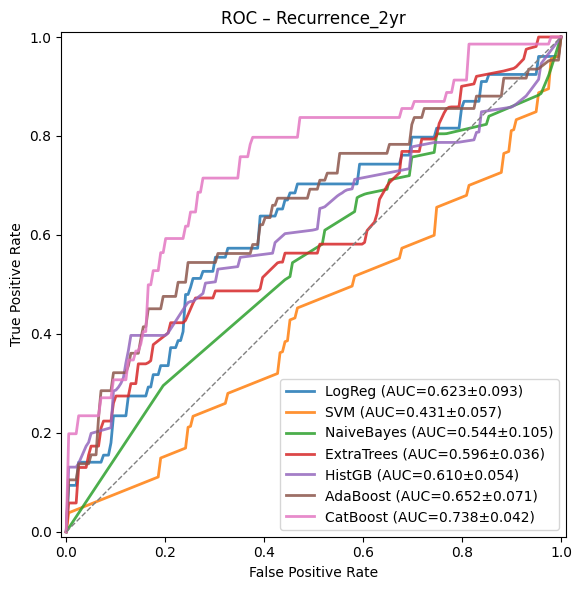

In [84]:
# ╔═╡ Cell 7 ═════════════════════════════════════════════════════════════╗
# ------------- 7. Plot combined ROC figure -----------------------------
plt.figure(figsize=(8, 6))
colors = plt.rcParams["axes.prop_cycle"].by_key()["color"]

for idx, disp in enumerate(roc_displays):
    disp.plot(ax=plt.gca(), alpha=0.85, linewidth=2, color=colors[idx % len(colors)])

plt.plot([0, 1], [0, 1], "--", color="grey", linewidth=1)
plt.title("ROC – Recurrence_2yr")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()

In [85]:
# ╔═╡ Cell 7b – Bootstrap AUC 95% CI ─────────────────────────────────╗
import numpy as np
from sklearn.metrics    import roc_auc_score

# 1) ground truth
y_true = y_test.reset_index(drop=True)

# 2) pipeline handles preprocessing internally
y_prob = models["XGBoost"].predict_proba(
    X_test.reset_index(drop=True)
)[:, 1]

# 3) bootstrap
n_bootstraps = 1000
rng = np.random.RandomState(42)
scores = []

for _ in range(n_bootstraps):
    idx = rng.randint(0, len(y_true), len(y_true))
    if len(np.unique(y_true.iloc[idx])) < 2:
        continue
    scores.append(roc_auc_score(y_true.iloc[idx], y_prob[idx]))

ci_lower, ci_upper = np.percentile(scores, [2.5, 97.5])
auc_mean = roc_auc_score(y_true, y_prob)

print(f"AUC (test)         = {auc_mean:.3f}")
print(f"95% CI (bootstrap)= [{ci_lower:.3f}, {ci_upper:.3f}]")


KeyError: 'XGBoost'

In [ ]:
# ╔═╡ Cell 8 – Bar chart of mean ShuffleSplit AUCs with ±std ─════════╗
import numpy as np

# 1. Compute mean & std per model
mean_aucs = {name: np.mean(vals) for name, vals in aucs.items()}
std_aucs  = {name: np.std(vals)  for name, vals in aucs.items()}

# 2. Sort by mean AUC
sorted_items = sorted(mean_aucs.items(), key=lambda kv: kv[1])
labels, means = zip(*sorted_items)
stds = [std_aucs[name] for name in labels]

# 3. Plot bars with error bars
plt.figure(figsize=(10, 4))
bars = plt.bar(labels, means, yerr=stds, capsize=4)
plt.ylim(0, 1)
plt.ylabel("Mean AUC")
plt.title("Mean AUC ± Std – 80/20 ShuffleSplit (5 runs)")
plt.xticks(rotation=30, ha="right")

# 4. Annotate each bar with mean±std
for bar, m, s in zip(bars, means, stds):
    text = f"{m:.3f}±{s:.3f}"
    plt.annotate(
        text,
        xy=(bar.get_x() + bar.get_width() / 2, bar.get_height()),
        xytext=(0, 3), textcoords="offset points",
        ha="center", va="bottom", fontsize=8
    )

plt.tight_layout()
plt.show()


In [ ]:
# ╔═╡ Cell 9 – Quick summary table with mean ± std AUC ─════════════╗
import numpy as np

# Build a list of records
records = []
for name, vals in aucs.items():
    records.append({
        "Model":    name,
        "Mean AUC": np.mean(vals),
        "Std AUC":  np.std(vals)
    })

# Create DataFrame and sort
summary = (
    pd.DataFrame(records)
      .sort_values("Mean AUC", ascending=False)
      .reset_index(drop=True)
)

# Plain‐text print
print(summary.to_string(index=False, float_format="%.3f"))


In [ ]:
# ╔═╡ Cell 9.5′ – Pipeline + sigmoid calibration ─────────────────────╗
from sklearn.pipeline            import Pipeline
from sklearn.calibration        import CalibratedClassifierCV
from xgboost                    import XGBClassifier

# 1) Rebuild a pipeline: preprocessing → XGBoost
xgb_pipe = Pipeline([
    ("prep", preprocessor),      # your ColumnTransformer!
    ("clf", XGBClassifier(
        n_estimators       = best_n_rounds,
        learning_rate      = 0.01,
        max_depth          = 5,
        subsample          = 0.8,
        colsample_bytree   = 0.8,
        gamma              = 1.0,
        reg_alpha          = 0.1,
        reg_lambda         = 1.0,
        scale_pos_weight   = (y_train==0).sum()/(y_train==1).sum(),
        objective          = "binary:logistic",
        eval_metric        = "auc",
        tree_method        = "hist",
        use_label_encoder  = False,
        random_state       = RANDOM_STATE
    ))
])

# 2) Wrap that in a sigmoid calibrator (Platt scaling) with 3-fold CV
calibrator = CalibratedClassifierCV(
    base_estimator = xgb_pipe,
    method         = "sigmoid",   # more stable on small samples
    cv             = 3            # internal 3-fold for calibration
)

# 3) Fit _only_ on your training set
calibrator.fit(X_train, y_train)

# 4) Save back into your models dict
models["XGBoost_Calibrated"] = calibrator


In [ ]:
# ╔═╡ Cell 10 – Calibration curve + Brier score ─────────────────══════╗
from sklearn.calibration import calibration_curve
from sklearn.metrics      import brier_score_loss
import matplotlib.pyplot as plt

# 1) Raw probabilities (before calibration) on the raw X_test
y_prob_raw = models["XGBoost"].predict_proba(X_test)[:, 1]

# 2) Calibrated probabilities (same raw X_test)
y_prob_cal = models["XGBoost_Calibrated"].predict_proba(X_test)[:, 1]

# 3) Compute calibration curves (fraction of positives vs. mean predicted)
frac_pos_raw, mean_pred_raw = calibration_curve(y_test, y_prob_raw, n_bins=10)
frac_pos_cal, mean_pred_cal = calibration_curve(y_test, y_prob_cal, n_bins=10)

plt.figure(figsize=(6, 6))
plt.plot(mean_pred_raw, frac_pos_raw, "s-", label="XGBoost (raw)")
plt.plot(mean_pred_cal, frac_pos_cal, "o-", label="XGBoost (calibrated)")
plt.plot([0, 1], [0, 1], "k--", label="Perfectly calibrated")
plt.xlabel("Mean predicted probability")
plt.ylabel("Fraction of positives")
plt.title("Calibration curve – XGBoost")
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()

# 4) Brier scores for raw vs. calibrated
print("Brier score (raw)     :", brier_score_loss(y_test, y_prob_raw))
print("Brier score (calibr.) :", brier_score_loss(y_test, y_prob_cal))


In [ ]:
# ╔═╡ Cell 11 – Precision–Recall & threshold‐tuning ════════════════╗
from sklearn.metrics import precision_recall_curve, f1_score

y_prob = models["XGBoost"].predict_proba(X_test)[:,1]
precision, recall, thresholds = precision_recall_curve(y_test, y_prob)

plt.figure(figsize=(6,4))
plt.plot(recall, precision, label="XGBoost PR-curve")
plt.xlabel("Recall"); plt.ylabel("Precision")
plt.title("Precision–Recall curve")
plt.legend()
plt.tight_layout()
plt.show()

# F1 vs threshold
f1s = [f1_score(y_test, y_prob>=t) for t in thresholds]
opt_idx = np.argmax(f1s)
print(f"Best F1={f1s[opt_idx]:.3f} at threshold={thresholds[opt_idx]:.2f}")


In [ ]:
# ╔═╡ Cell 11 – SHAP summary plots for XGBoost ─══════════════════════╗
import shap
import matplotlib.pyplot as plt

# 1) Build a SHAP Explainer on your training set
explainer = shap.Explainer(models["XGBoost"], X_train)

# 2) Compute SHAP values on the test set: this returns an Explanation object
shap_values = explainer(X_test)

# 3) Beeswarm (dot) plot of per‐sample SHAP values
plt.figure(figsize=(10, 6))
shap.plots.beeswarm(shap_values, max_display=20, show=False)
plt.title("SHAP Beeswarm – XGBoost (Recurrence_2yr)")
plt.tight_layout()
plt.show()

# 4) Bar plot of mean(|SHAP|) for each feature
plt.figure(figsize=(6, 8))
shap.plots.bar(shap_values, max_display=20, show=False)
plt.title("mean(|SHAP|) – XGBoost")
plt.tight_layout()
plt.show()

In [ ]:
# ╔═╡ Cell 12 – Partial dependence for top features ═══════════════╗
import numpy as np
from sklearn.inspection import PartialDependenceDisplay
import matplotlib.pyplot as plt

# 1) Extract the raw SHAP values array from the Explanation
#    shap_values was created in Cell 10 via `explainer(X_test)`
vals = shap_values.values
# If it’s a 3‐D array (n_samples x 2 classes x n_features),
# pick the positive‐class slice:
if vals.ndim == 3:
    vals = vals[:, 1, :]

# 2) Compute mean(|SHAP|) per feature and grab top-3 indices
importances = np.abs(vals).mean(axis=0)
top_idx    = np.argsort(importances)[::-1][:3]
top_feats  = [X_test.columns[i] for i in top_idx]

print("Top 3 features by |SHAP|:", top_feats)

# 3) Plot partial dependence for those top 3
fig, axes = plt.subplots(1, len(top_feats), figsize=(4*len(top_feats), 4))
PartialDependenceDisplay.from_estimator(
    models["XGBoost"],
    X_test,
    features=top_feats,
    ax=axes
)
plt.tight_layout()
plt.show()


In [ ]:
# ╔═╡ Cell 13 – Permutation importance ══════════════════════════╗
from sklearn.inspection import permutation_importance

r = permutation_importance(
    models["XGBoost"], X_test, y_test,
    scoring="roc_auc", n_repeats=10, random_state=RANDOM_STATE
)
perm_df = pd.Series(r.importances_mean, index=X_test.columns).sort_values(ascending=False)
perm_df.head(10).plot.barh()
plt.xlabel("Mean decrease in AUC")
plt.title("Permutation importance – XGBoost")
plt.tight_layout()
plt.show()

In [ ]:
# ╔═╡ Cell 14 – Manual Decision Curve Analysis (Net Benefit) ─════════════╗
import numpy as np
import matplotlib.pyplot as plt

# 1) True labels & predicted probabilities (from your best model)
y_true = y_test.values        # shape (n_samples,)
y_prob = models["XGBoost"].predict_proba(X_test)[:,1]

N      = len(y_true)
preval = y_true.mean()        # event rate

# 2) Define a grid of thresholds
thresholds = np.linspace(0.01, 0.99, 99)

# 3) Compute net benefit for each threshold
nb_model = []
nb_all   = []
nb_none  = np.zeros_like(thresholds)

for pt in thresholds:
    preds = (y_prob >= pt).astype(int)
    TP    = ((preds == 1) & (y_true == 1)).sum()
    FP    = ((preds == 1) & (y_true == 0)).sum()
    # NB = TP/N - FP/N * (pt/(1-pt))
    nb    = TP/N - FP/N * (pt/(1-pt))
    nb_model.append(nb)
    nb_all.append(preval - (1 - preval)*(pt/(1-pt)))

# 4) Plot
plt.figure(figsize=(7,5))
plt.plot(thresholds, nb_model, label="XGBoost")
plt.plot(thresholds, nb_all,   label="Treat All",    linestyle="--")
plt.plot(thresholds, nb_none,  label="Treat None",   linestyle=":")
plt.xlabel("Decision Threshold")
plt.ylabel("Net Benefit")
plt.title("Decision Curve Analysis – Recurrence_2yr")
plt.legend(loc="best")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


In [82]:
# ╔═╡ Cell 15 – SHAP summary for CatBoost (Recurrence_2yr) ─════════════╗
import shap
import matplotlib.pyplot as plt

# 1) Prepare CatBoost-friendly data
X_test_cb = prepare_for_catboost(X_test, cat)

# 2) Build a TreeExplainer that can handle your string categories
explainer_cb = shap.TreeExplainer(
    models["CatBoost"],
    feature_perturbation="tree_path_dependent"
)

# 3) Compute the full SHAP matrix for the positive/recurrence class
shap_values_cb = explainer_cb.shap_values(X_test_cb)
# shap_values_cb should now be shape (n_samples, n_features)

print("🔎 SHAP values shape:", shap_values_cb.shape)

# 4) Beeswarm (dot) plot
plt.figure(figsize=(10, 6))
shap.summary_plot(
    shap_values_cb,    # the full matrix, not a single row
    X_test_cb,
    max_display=20,
    show=False
)
plt.title("SHAP Beeswarm – CatBoost (Recurrence_2yr)")
plt.tight_layout()
plt.show()

# 5) Bar plot of mean(|SHAP|) global importances
plt.figure(figsize=(6, 8))
shap.summary_plot(
    shap_values_cb,
    X_test_cb,
    plot_type="bar",
    max_display=20,
    show=False
)
plt.title("mean(|SHAP|) – CatBoost")
plt.tight_layout()
plt.show()


InvalidModelError: Model type not yet supported by TreeExplainer: <class 'sklearn.pipeline.Pipeline'>

In [ ]:
# ╔═╡ Cell 16 – Partial dependence (top 3 CatBoost features) ═════════╗
from sklearn.inspection import PartialDependenceDisplay
import numpy as np

# pick the top 3 by mean(|SHAP|)
top3 = X_test_cb.columns[np.argsort(np.abs(shap_values_cb).mean(0))[-3:]]

fig, axes = plt.subplots(1, 3, figsize=(4*3, 4))
PartialDependenceDisplay.from_estimator(
    models["CatBoost"],      # your final CatBoost instance
    X_test_cb,               # preprocessed test set
    features=list(top3),     # names of the top 3
    ax=axes
)
plt.suptitle("Partial Dependence – CatBoost", y=1.02)
plt.tight_layout()
plt.show()


In [ ]:
# ╔═╡ Cell 17 – Permutation importance (CatBoost) ═════════════════════╗
from sklearn.inspection import permutation_importance

r = permutation_importance(
    models["CatBoost"],
    X_test_cb, y_test,
    scoring="roc_auc",
    n_repeats=20,
    random_state=RANDOM_STATE,
    n_jobs=-1
)

# sort and plot
import pandas as pd
imp_df = pd.DataFrame({
    "feature": X_test_cb.columns,
    "mean_decrease_auc": r.importances_mean
}).sort_values("mean_decrease_auc", ascending=False).head(20)

plt.figure(figsize=(6,8))
plt.barh(imp_df["feature"][::-1], imp_df["mean_decrease_auc"][::-1])
plt.xlabel("Mean decrease in AUC")
plt.title("Permutation importance – CatBoost")
plt.tight_layout()
plt.show()


In [ ]:
# ╔═╡ Cell 18 – Decision curve (CatBoost) ─────────────────────────────╗
import numpy as np
from sklearn.metrics import roc_curve

# (you can reuse your decision‐curve function or library)
# here’s a very simple “net benefit” curve for illustration:
probs = models["CatBoost"].predict_proba(X_test_cb)[:,1]
thresholds = np.linspace(0,1,100)
n = len(y_test)
event_rate = y_test.mean()

nb = []
for t in thresholds:
    tp = ((probs >= t) & (y_test==1)).sum()
    fp = ((probs >= t) & (y_test==0)).sum()
    nb.append((tp/n) - (fp/n)*(t/(1-t)))  # simple net‐benefit formula

plt.plot(thresholds, nb, label="CatBoost")
plt.plot(thresholds, np.zeros_like(thresholds), '--', label="Treat none")
plt.plot(thresholds,
         event_rate - (1-event_rate)*(thresholds/(1-thresholds)),
         ':', label="Treat all")
plt.xlabel("Decision threshold")
plt.ylabel("Net benefit")
plt.title("Decision Curve Analysis – CatBoost")
plt.legend()
plt.tight_layout()
plt.show()
